**INTRODUCTION**
- Goal: Extract main artistical topics for each department
- Outline the methodology and techniques used: NLP methods

**EXPLORATORY DATA ANALYSIS (EDA)**
- Load and preview the data
- Check for missing values and clean the data as necessary
- Plot some visualizations to understand the data and binning features according to their distributions

**FEATURE ENGINEERING**
- Perform some initial text pre-processing such as removing stop words, punctuations, digits, and converting all characters to lowercase.
- Transform the text data using techniques such as tokenization, stemming, and lemmatization, translation of foreign words

**MODELLING**
- Apply a topic extraction model such as Latent Dirichlet Allocation (LDA) to identify the topics in the text data
- Assign 3 main topics to each department based on the dominant topic for each document

**CONCLUSION**
- Discuss the findings and their implications
- Provide recommendations for future research

In [1]:
#All the packages used in the follow workflow are imported in this cell
import time
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import spacy
import langid
from googletrans import Translator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Read Data
df = pd.read_csv('data.txt', sep=",")
print(df.shape)
df.head()

/Users/amiolla/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3139: DtypeWarning: Columns (5,7,10,11,12,13,14,34,35,36,37,38,39,40,41,42,43,44,45,46) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(477804, 54)


,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Object ID,Gallery Number,Department,AccessionYear,Object Name,Title,...,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
0,1979.486.1,False,False,False,1,NaN,The American Wing,1979,Coin,One-dollar Liberty Head Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/1,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
1,1980.264.5,False,False,False,2,NaN,The American Wing,1980,Coin,Ten-dollar Liberty Head Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/2,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
2,67.265.9,False,False,False,3,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/3,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
3,67.265.10,False,False,False,4,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/4,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
4,67.265.11,False,False,False,5,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/5,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN


## EDA 

In [3]:
#Original columns included in the dataset
df.columns

Index(['Object Number', 'Is Highlight', 'Is Timeline Work', 'Is Public Domain',
       'Object ID', 'Gallery Number', 'Department', 'AccessionYear',
       'Object Name', 'Title', 'Culture', 'Period', 'Dynasty', 'Reign',
       'Portfolio', 'Constituent ID', 'Artist Role', 'Artist Prefix',
       'Artist Display Name', 'Artist Display Bio', 'Artist Suffix',
       'Artist Alpha Sort', 'Artist Nationality', 'Artist Begin Date',
       'Artist End Date', 'Artist Gender', 'Artist ULAN URL',
       'Artist Wikidata URL', 'Object Date', 'Object Begin Date',
       'Object End Date', 'Medium', 'Dimensions', 'Credit Line',
       'Geography Type', 'City', 'State', 'County', 'Country', 'Region',
       'Subregion', 'Locale', 'Locus', 'Excavation', 'River', 'Classification',
       'Rights and Reproduction', 'Link Resource', 'Object Wikidata URL',
       'Metadata Date', 'Repository', 'Tags', 'Tags AAT URL',
       'Tags Wikidata URL'],
      dtype='object')

In [4]:
#Filter only the features useful for the final goal according to their meaning described in https://metmuseum.github.io/
df = df[['Object ID','Is Highlight', 'Is Public Domain', 'Department', 'Object Name', 'Title', 'Culture', 'Period', 'Dynasty', 'Reign', 'Portfolio', 
         'Artist Role', 'Artist Alpha Sort', 'Artist Nationality', 'Artist End Date', 'Artist Gender',
         'Object Date', 'Medium', 'Dimensions',
         'Geography Type', 'City', 'State', 'Country', 'Classification']]

print(df.shape)
df.head()

(477804, 24)


,Object ID,Is Highlight,Is Public Domain,Department,Object Name,Title,Culture,Period,Dynasty,Reign,...,Artist End Date,Artist Gender,Object Date,Medium,Dimensions,Geography Type,City,State,Country,Classification
0,1,False,False,The American Wing,Coin,One-dollar Liberty Head Coin,NaN,NaN,NaN,NaN,...,1869,NaN,1853,Gold,Dimensions unavailable,NaN,NaN,NaN,NaN,NaN
1,2,False,False,The American Wing,Coin,Ten-dollar Liberty Head Coin,NaN,NaN,NaN,NaN,...,1844,NaN,1901,Gold,Dimensions unavailable,NaN,NaN,NaN,NaN,NaN
2,3,False,False,The American Wing,Coin,Two-and-a-Half Dollar Coin,NaN,NaN,NaN,NaN,...,NaN,NaN,1909–27,Gold,Diam. 11/16 in. (1.7 cm),NaN,NaN,NaN,NaN,NaN
3,4,False,False,The American Wing,Coin,Two-and-a-Half Dollar Coin,NaN,NaN,NaN,NaN,...,NaN,NaN,1909–27,Gold,Diam. 11/16 in. (1.7 cm),NaN,NaN,NaN,NaN,NaN
4,5,False,False,The American Wing,Coin,Two-and-a-Half Dollar Coin,NaN,NaN,NaN,NaN,...,NaN,NaN,1909–27,Gold,Diam. 11/16 in. (1.7 cm),NaN,NaN,NaN,NaN,NaN


In [5]:
#check types of the columns
df.dtypes

Object ID              int64
Is Highlight            bool
Is Public Domain        bool
Department            object
Object Name           object
Title                 object
Culture               object
Period                object
Dynasty               object
Reign                 object
Portfolio             object
Artist Role           object
Artist Alpha Sort     object
Artist Nationality    object
Artist End Date       object
Artist Gender         object
Object Date           object
Medium                object
Dimensions            object
Geography Type        object
City                  object
State                 object
Country               object
Classification        object
dtype: object

In [6]:
# replace field that's entirely space (or empty) with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

In [7]:
#Check Proportion NaN for each col and delete cols with more than 60% of NaN (arbitrary value chosen according to the print below)
print(df.isnull().sum()* 100 / len(df))
df = df.loc[:, df.isnull().mean() < .6]

Object ID              0.000000
Is Highlight           0.000000
Is Public Domain       0.000000
Department             0.000000
Object Name            0.353911
Title                  6.108153
Culture               56.597475
Period                80.963742
Dynasty               95.137546
Reign                 97.650501
Portfolio             95.078107
Artist Role           42.772350
Artist Alpha Sort     42.368837
Artist Nationality    56.520665
Artist End Date       48.914827
Artist Gender         78.430277
Object Date            2.902236
Medium                 1.491616
Dimensions            15.762740
Geography Type        87.490896
City                  93.217512
State                 99.466308
Country               84.146010
Classification        16.367799
dtype: float64


Features were deleted for the following reasons:
1) Out of scope for this exercise (e.g., primaryImageSmall useful information for a Computer Vision approach);
2) Overlapped information (e.g., County and State)
3) Majority of Missing values ('frequently null' as mentioned in the site)
4) Not valuable information for the goal of this worflow (e.g., Repository containing always the same information)

In [8]:
#Keep the rows where the Title and the Artist of the object is not NaN
print('Number of unavailable objects: ', df['Title'].isna().sum())
print('Number of unavailable Artists: ', df['Artist Alpha Sort'].isna().sum())
df = df.dropna(subset=['Title', 'Artist Alpha Sort'], how='any')
print('New shape of the dataframe after NaN removal: ', df.shape)

Number of unavailable objects:  29185
Number of unavailable Artists:  202440
New shape of the dataframe after NaN removal:  (269987, 15)


In [9]:
#Check for duplicated objects
print('Number of Unique objects included in the dataset: ', df.groupby(['Title', 'Artist Alpha Sort']).ngroups) 
df = df.drop_duplicates(subset=['Title', 'Artist Alpha Sort'])
print('New shape after duplicates objects removal: ', df.shape)
df.head(3)

Number of Unique objects included in the dataset:  224786
New shape after duplicates objects removal:  (224786, 15)


,Object ID,Is Highlight,Is Public Domain,Department,Object Name,Title,Culture,Artist Role,Artist Alpha Sort,Artist Nationality,Artist End Date,Object Date,Medium,Dimensions,Classification
0,1,False,False,The American Wing,Coin,One-dollar Liberty Head Coin,NaN,Maker,"Longacre, James Barton",American,1869,1853,Gold,Dimensions unavailable,NaN
1,2,False,False,The American Wing,Coin,Ten-dollar Liberty Head Coin,NaN,Maker,"Gobrecht, Christian",NaN,1844,1901,Gold,Dimensions unavailable,NaN
9,10,False,False,The American Wing,Coin,Two-and-a-half-dollar Indian Head Coin,NaN,Maker,"Pratt, Bela Lyon",NaN,1917,1912,Gold,Dimensions unavailable,NaN


The name of the object can be the same but the artist can be different. That's the reason why also the name of the artist is included in the count of nunique values.
This logic is based on the assumption that there are no typo or inflected forms in the Artist Name (step to include in Future directions/improvements)

## Feature Engineering

### Boolean features

In [10]:
#Convert True and False into binary categories 
df['Is Highlight'].replace({True: 'popular', False: 'unpopular'}, inplace=True)
df['Is Public Domain'].replace({True: 'public', False: 'private'}, inplace=True)

### Feature containing the surname of the artist

In [11]:
#Extract only surname artist
df['Artist Alpha Sort'] = df['Artist Alpha Sort'].str.split(',').str[0]
df.head(3)

,Object ID,Is Highlight,Is Public Domain,Department,Object Name,Title,Culture,Artist Role,Artist Alpha Sort,Artist Nationality,Artist End Date,Object Date,Medium,Dimensions,Classification
0,1,unpopular,private,The American Wing,Coin,One-dollar Liberty Head Coin,NaN,Maker,Longacre,American,1869,1853,Gold,Dimensions unavailable,NaN
1,2,unpopular,private,The American Wing,Coin,Ten-dollar Liberty Head Coin,NaN,Maker,Gobrecht,NaN,1844,1901,Gold,Dimensions unavailable,NaN
9,10,unpopular,private,The American Wing,Coin,Two-and-a-half-dollar Indian Head Coin,NaN,Maker,Pratt,NaN,1917,1912,Gold,Dimensions unavailable,NaN


### Features containing Years as values

In [12]:
#Convert object into str
df['Artist End Date'] = df['Artist End Date'].astype(str)
df['Object Date'] = df['Object Date'].astype(str)

# remove whitespace using apply
df['Artist End Date']=df['Artist End Date'].apply(lambda x: x.strip())
df['Object Date']=df['Object Date'].apply(lambda x: x.strip())

# convert columns to numeric
df['Artist End Date'] = pd.to_numeric(df['Artist End Date'], errors='coerce')
df['Object Date'] = pd.to_numeric(df['Object Date'], errors='coerce')

# fill missing values with 0
df['Artist End Date'] = df['Artist End Date'].fillna(0)
df['Object Date'] = df['Object Date'].fillna(0)

# convert columns to integer
df['Artist End Date'] = df['Artist End Date'].astype(int)
df['Object Date'] = df['Object Date'].astype(int)

Text(0.5, 1.0, "Distribution of Artists' Death Year")

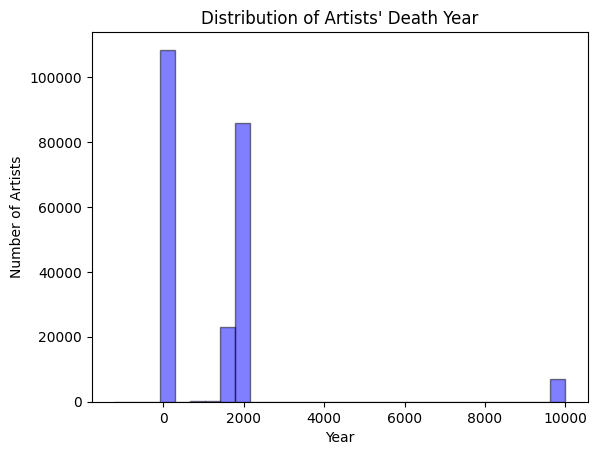

In [13]:
# Plot the histogram to analyze distribution of Artist
plt.hist(df['Artist End Date'], bins=30, alpha=0.5, color='blue', edgecolor='black')

# Add labels and title to the plot
plt.xlabel('Year')
plt.ylabel('Number of Artists')
plt.title('Distribution of Artists\' Death Year')

In [14]:
#check reason of outliers
df[df['Artist End Date']>2023]

,Object ID,Is Highlight,Is Public Domain,Department,Object Name,Title,Culture,Artist Role,Artist Alpha Sort,Artist Nationality,Artist End Date,Object Date,Medium,Dimensions,Classification
125,134,unpopular,public,The American Wing,Bedroom,Architectural elements from a Retiring Room in...,"American, Shaker",Maker,United Society of Believers in Christ’s Second...,NaN,9999,0,Wood,Dimensions unavailable,NaN
128,139,unpopular,public,The American Wing,Argand lamp,Argand Lamp,NaN,Maker,Messenger Company,NaN,9999,0,"Bronze, gilt brass",17 7/8 x 17 x 7 7/8 in. (45.4 x 43.2 x 20 cm),NaN
240,281,unpopular,private,The American Wing,Astral lamp,Astral Lamp,American,Maker,Hooper,NaN,9999,0,"Bronze, glass",H. 26 1/4 in. (66.7 cm); Diam. 9 1/2 in. (24.1...,NaN
292,338,unpopular,private,The American Wing,Wash basin,Wash basin,American,Maker,Eberly and Company J.,NaN,9999,0,Earthenware with slip decoration,Diam. 13 1/2 in. (34.3 cm),NaN
294,340,unpopular,private,The American Wing,Basin,Basin,American,Maker,Griswold,NaN,9999,0,Pewter,1 5/8 x 6 5/8 x 6 5/8 in. (4.1 x 16.8 x 16.8 cm),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477446,856896,unpopular,private,Drawings and Prints,"Print, postcard",Magnitude Manor,NaN,Artist,Langenstein,NaN,9999,1986,Offset lithographs,Sheet: 4 1/4 in. × 6 in. (10.8 × 15.2 cm),Prints|Postcards
477500,857074,popular,private,The Libraries,NaN,Conjure,NaN,Artist,Martin,NaN,9999,2021,NaN,"ii, 59 pages : illustrations (chiefly color) ;...",NaN
477502,857076,popular,private,The Libraries,NaN,Fearless beadwork : improvisational peyote sti...,NaN,Author,Scott,NaN,9999,1994,NaN,32 unnumbered pages : illustrations (some colo...,NaN
477548,857447,unpopular,private,The Libraries,NaN,Riddle ma riddle as I suppose : riddles from t...,NaN,Author,Kennedy,NaN,9999,2002,NaN,1 volume (accordion pleated) : color illustrat...,NaN


Text(0.5, 1.0, "Distribution of Artists' Death Year")

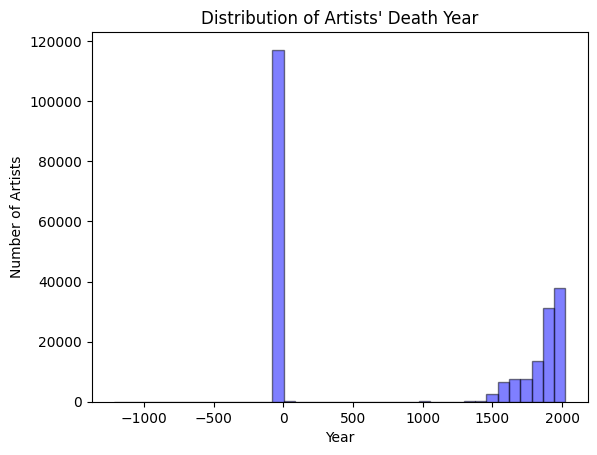

In [15]:
#Replace impossible values with 0
df['Artist End Date'] = np.where(df['Artist End Date'] > 2023, 0, df['Artist End Date'])

# Plot the histogram to analyze distribution of Artist
plt.hist(df['Artist End Date'], bins=40, alpha=0.5, color='blue', edgecolor='black')

# Add labels and title to the plot
plt.xlabel('Year')
plt.ylabel('Number of Artists')
plt.title('Distribution of Artists\' Death Year')

Text(0.5, 1.0, 'Distribution of Object Date')

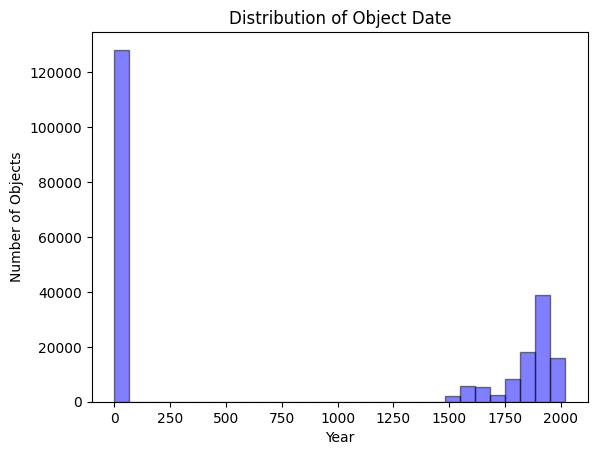

In [16]:
# Plot the histogram to analyze distribution of Artist
plt.hist(df['Object Date'], bins=30, alpha=0.5, color='blue', edgecolor='black')

# Add labels and title to the plot
plt.xlabel('Year')
plt.ylabel('Number of Objects')
plt.title('Distribution of Object Date')

In [17]:
#Function that classify the year into a artistic period according to the domain knowledge
def classify_year_artistic(year):
    if year<1:
        return "Unknown"
    elif year < 1420:
        return "Medieval"
    elif year < 1470:
        return "Early Medieval"
    elif year < 1520:
        return "Mid Medieval"
    elif year < 1570:
        return "Late Medieval"
    elif year < 1600:
        return "Early Renaissance"
    elif year < 1650:
        return "High Renaissance"
    elif year < 1700:
        return "Late Renaissance"
    elif year < 1750:
        return "Early Baroque"
    elif year < 1800:
        return "Late Baroque"
    elif year < 1850:
        return "Neoclassical"
    elif year < 1900:
        return "Romanticism"
    elif year < 1950:
        return "Impressionism"
    elif year < 2000:
        return "Modern"
    else:
        return "Contemporary"

In [18]:
#classify features containing year into historical artistic periods according to the bins shown in the hist + personal domain knowledge
df['Historical Artist End Date'] = df['Artist End Date'].apply(lambda x: classify_year_artistic(int(x)))
df['Historical Period Object'] = df['Object Date'].apply(lambda x: classify_year_artistic(int(x)))

#drop converted features 
df = df.drop(['Artist End Date', 'Object Date'], axis=1)

In [19]:
df['Historical Artist End Date'].value_counts()

Unknown              117168
Modern                27302
Impressionism         23134
Romanticism           13636
Neoclassical           8328
Contemporary           7906
Late Baroque           6415
Late Renaissance       5028
Late Medieval          4454
High Renaissance       4434
Early Baroque          3257
Early Renaissance      1932
Mid Medieval            962
Medieval                622
Early Medieval          208
Name: Historical Artist End Date, dtype: int64

In [20]:
df['Historical Period Object'].value_counts()

Unknown              128176
Romanticism           26752
Impressionism         22243
Modern                15750
Neoclassical           8186
Late Baroque           6370
High Renaissance       5220
Late Medieval          3209
Late Renaissance       2214
Early Renaissance      2154
Contemporary           1918
Early Baroque          1822
Mid Medieval            731
Early Medieval           27
Medieval                 14
Name: Historical Period Object, dtype: int64

### Features containing indications about the size the object

In [21]:
#Work with Dimensions column 
df['Dimensions'] = df['Dimensions'].astype(str)
df['Dimensions'] = df['Dimensions'].str.replace(" × "," x ") #some cases may lead to errors in the split
df['Dimensions'] = df['Dimensions'].apply(lambda x: x.strip())

#Delete possible string 'cm' in the col
df['Dimensions'] = df['Dimensions'].str.replace(r'cm', '') 

#Extraction dimensions from the column Dimension
df['Dimensions'] = df['Dimensions'].str.extract(r"\((.*?)\)", expand=False)
df[['length_cm', 'width_cm', 'height_cm']] = df['Dimensions'].str.split( ' x ', 2, expand=True) 

# #Convert object into str
df['length_cm'] = df['length_cm'].astype(str)
df['width_cm'] = df['width_cm'].astype(str)
df['height_cm'] = df['height_cm'].astype(str)

# convert column to numeric
df['length_cm'] = pd.to_numeric(df['length_cm'], errors='coerce')
df['width_cm'] = pd.to_numeric(df['width_cm'], errors='coerce')
df['height_cm'] = pd.to_numeric(df['height_cm'], errors='coerce')

#Replace NaN with 1
df['length_cm'] = df['length_cm'].fillna(1)
df['width_cm'] = df['width_cm'].fillna(1)
df['height_cm'] = df['height_cm'].fillna(1)

#convert 'Artist Begin Date' column to integer
df['length_cm'] = df['length_cm'].astype(int)
df['width_cm'] = df['width_cm'].astype(int)
df['height_cm'] = df['height_cm'].astype(int)

#use the Pythagorean theorem to calculate the diagonal of the parallelepiped using the three sides of the object
df['size_category'] = ((df['length_cm']**2) + (df['width_cm']**2) + (df['height_cm']**2))**0.5

Text(0.5, 1.0, 'Distribution of log-transformed size of the objects')

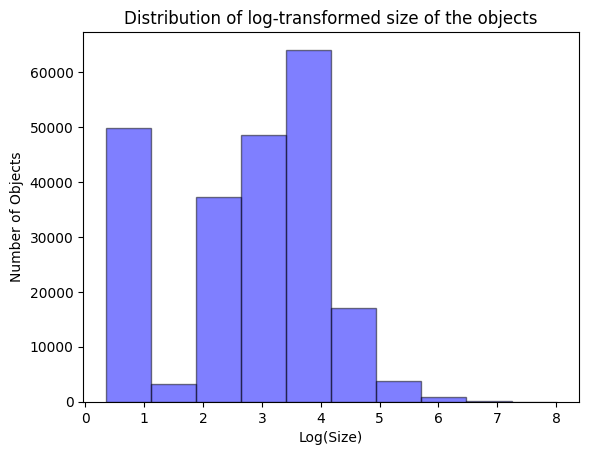

In [22]:
# Transform the data using logarithm
log_data = np.log(df['size_category'])

# Plot the log-transformed data using histogram
plt.hist(log_data, bins=10, alpha=0.5, color='blue', edgecolor='black')

# Add labels and title to the plot
plt.xlabel('Log(Size)')
plt.ylabel('Number of Objects')
plt.title('Distribution of log-transformed size of the objects')

In [23]:
#Convert into log scale the size
df['size_category_log'] = np.log(df['size_category'])

# Create bins and labels to transform numerical into categorical feature
labels = ['Tiny', 'Small', 'XSmall', 'Medium', 'Large', 'XLarge']
df['size_category_log'] = pd.qcut(df['size_category_log'], q=6, labels = labels)
df['size_category_log'] = df['size_category_log'].astype(str)

#Drop original Dimension
df = df.drop(['Dimensions', 'length_cm', 'width_cm', 'height_cm', 'size_category'], axis=1)
df['size_category_log'].value_counts()

Tiny      49365
Medium    37486
XLarge    37450
XSmall    37314
Large     36786
Small     26385
Name: size_category_log, dtype: int64

In [24]:
#convert name cols into lower case
df.columns = df.columns.str.lower()

print('Number of columns: ', len(df.columns))
df.dtypes

Number of columns:  15


object id                      int64
is highlight                  object
is public domain              object
department                    object
object name                   object
title                         object
culture                       object
artist role                   object
artist alpha sort             object
artist nationality            object
medium                        object
classification                object
historical artist end date    object
historical period object      object
size_category_log             object
dtype: object

### NLP Feature Engineering

In [25]:
#Create df including only object features
df_string = df.select_dtypes(include=object)
print(df_string.shape)
df_string.head()

(224786, 14)


,is highlight,is public domain,department,object name,title,culture,artist role,artist alpha sort,artist nationality,medium,classification,historical artist end date,historical period object,size_category_log
0,unpopular,private,The American Wing,Coin,One-dollar Liberty Head Coin,NaN,Maker,Longacre,American,Gold,NaN,Romanticism,Romanticism,Tiny
1,unpopular,private,The American Wing,Coin,Ten-dollar Liberty Head Coin,NaN,Maker,Gobrecht,NaN,Gold,NaN,Neoclassical,Impressionism,Tiny
9,unpopular,private,The American Wing,Coin,Two-and-a-half-dollar Indian Head Coin,NaN,Maker,Pratt,NaN,Gold,NaN,Impressionism,Impressionism,Tiny
10,unpopular,private,The American Wing,Coin,Two-and-a-half-dollar Liberty Head Coin,NaN,Maker,Gobrecht,NaN,Gold,NaN,Neoclassical,Impressionism,Tiny
11,unpopular,private,The American Wing,Coin,Twenty-dollar Liberty Head Coin,NaN,Maker,Longacre,American,Gold,NaN,Romanticism,Romanticism,Tiny


In [26]:
#Replace NaN wiht Unknown string
for column in df_string.columns:
    df_string[column].fillna('Unknown', inplace=True)

df_string.head()

/Users/amiolla/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,is highlight,is public domain,department,object name,title,culture,artist role,artist alpha sort,artist nationality,medium,classification,historical artist end date,historical period object,size_category_log
0,unpopular,private,The American Wing,Coin,One-dollar Liberty Head Coin,Unknown,Maker,Longacre,American,Gold,Unknown,Romanticism,Romanticism,Tiny
1,unpopular,private,The American Wing,Coin,Ten-dollar Liberty Head Coin,Unknown,Maker,Gobrecht,Unknown,Gold,Unknown,Neoclassical,Impressionism,Tiny
9,unpopular,private,The American Wing,Coin,Two-and-a-half-dollar Indian Head Coin,Unknown,Maker,Pratt,Unknown,Gold,Unknown,Impressionism,Impressionism,Tiny
10,unpopular,private,The American Wing,Coin,Two-and-a-half-dollar Liberty Head Coin,Unknown,Maker,Gobrecht,Unknown,Gold,Unknown,Neoclassical,Impressionism,Tiny
11,unpopular,private,The American Wing,Coin,Twenty-dollar Liberty Head Coin,Unknown,Maker,Longacre,American,Gold,Unknown,Romanticism,Romanticism,Tiny


In [27]:
#General function for cleaning the df 
def clean_string(string):
    # Replace any symbol with a space
    string = re.sub(r"[^\w\s]", " ", string)
    # Replace any digits with a space
    string = re.sub(r'\d', '', string)
    # Remove extra whitespaces
    string = re.sub(r"\s+", " ", string)
    # Convert to lowercase
    string = string.lower()
    # Tokenize the string
    words = word_tokenize(string)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Rejoin the words and return
    return " ".join(words)

#Function to iterate the function above for all the cols included in the df
def clean_string_columns(df_string):
    for column in df_string.columns:
        df_string[column] = df_string[column].apply(lambda x: clean_string(x))
    return df_string

In [28]:
#track of the starting time
start_time = time.time()

#cleaning functions
df_string_cleaned = clean_string_columns(df_string)

#track of the ending time
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time for the cleaning procedure in seconds: ", elapsed_time)
df_string_cleaned.head()

/var/folders/_8/6l0ts3md62v37vm4fspgf44d90tc3b/T/ipykernel_19072/1698096454.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_string[column] = df_string[column].apply(lambda x: clean_string(x))


Elapsed time for the cleaning procedure in seconds:  696.2922821044922


,is highlight,is public domain,department,object name,title,culture,artist role,artist alpha sort,artist nationality,medium,classification,historical artist end date,historical period object,size_category_log
0,unpopular,private,american wing,coin,one dollar liberty head coin,unknown,maker,longacre,american,gold,unknown,romanticism,romanticism,tiny
1,unpopular,private,american wing,coin,ten dollar liberty head coin,unknown,maker,gobrecht,unknown,gold,unknown,neoclassical,impressionism,tiny
9,unpopular,private,american wing,coin,two half dollar indian head coin,unknown,maker,pratt,unknown,gold,unknown,impressionism,impressionism,tiny
10,unpopular,private,american wing,coin,two half dollar liberty head coin,unknown,maker,gobrecht,unknown,gold,unknown,neoclassical,impressionism,tiny
11,unpopular,private,american wing,coin,twenty dollar liberty head coin,unknown,maker,longacre,american,gold,unknown,romanticism,romanticism,tiny


### Descriptive features of the object

In [29]:
# Classification: General term describing the artwork type
print(df_string_cleaned['classification'].value_counts().head(5))

prints             69867
photographs        22477
prints ephemera    21745
drawings           19282
unknown            17672
Name: classification, dtype: int64


In [30]:
# Object Name: Describes the physical type of the object
print(df_string_cleaned['object name'].value_counts().head(5))

print         84622
photograph    22586
drawing       21593
book          12753
painting       5360
Name: object name, dtype: int64


Classification and Object Name often overlaps on their information. I will group these features in one single column and then I will group the words with the same meaning

In [31]:
# Convert obj into strings
df_string_cleaned['classification'] = df_string_cleaned['classification'].apply(str).replace(np.nan, 'unknown', regex=True)
df_string_cleaned['object name'] = df_string_cleaned['object name'].apply(str).replace(np.nan, 'unknown', regex=True) 

# Combine 'classification' and 'object name' columns into one single string column
df_string_cleaned['combined_object_information'] = df_string_cleaned['classification'] + " " + df_string_cleaned['object name']

# Lemmatizes text
lemmatizer = WordNetLemmatizer()
df_string_cleaned['combined_object_information'] = df_string_cleaned['combined_object_information'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))
df_string_cleaned['combined_object_information'] = df_string_cleaned['combined_object_information'].str.replace("unknown", "")
df_string_cleaned = df_string_cleaned.drop(['classification', 'object name'], axis=1)

print(df_string_cleaned.shape)
df_string_cleaned.head()

/var/folders/_8/6l0ts3md62v37vm4fspgf44d90tc3b/T/ipykernel_19072/3002399036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_string_cleaned['classification'] = df_string_cleaned['classification'].apply(str).replace(np.nan, 'unknown', regex=True)
/var/folders/_8/6l0ts3md62v37vm4fspgf44d90tc3b/T/ipykernel_19072/3002399036.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_string_cleaned['object name'] = df_string_cleaned['object name'].apply(str).replace(np.nan, 'unknown', regex=True)


(224786, 13)


,is highlight,is public domain,department,title,culture,artist role,artist alpha sort,artist nationality,medium,historical artist end date,historical period object,size_category_log,combined_object_information
0,unpopular,private,american wing,one dollar liberty head coin,unknown,maker,longacre,american,gold,romanticism,romanticism,tiny,coin
1,unpopular,private,american wing,ten dollar liberty head coin,unknown,maker,gobrecht,unknown,gold,neoclassical,impressionism,tiny,coin
9,unpopular,private,american wing,two half dollar indian head coin,unknown,maker,pratt,unknown,gold,impressionism,impressionism,tiny,coin
10,unpopular,private,american wing,two half dollar liberty head coin,unknown,maker,gobrecht,unknown,gold,neoclassical,impressionism,tiny,coin
11,unpopular,private,american wing,twenty dollar liberty head coin,unknown,maker,longacre,american,gold,romanticism,romanticism,tiny,coin


### Translate Title of the Object in English if it is in another language

The choice to translate only the Title of the object is due to the following reasons:
1) speed up the translation process
2) to not translate the name of the author
3) avoid useless iterations in cols that I am sure are correct (e.g., is highligh, is public domain and so forth)

However, the df used contains more than 200K rows, and it connects to an API for the translation causing an expensive computational time of the operation.
In order to show the efficacy of the function, only a subsample of df is taken for the purpose of this demonstration and for the last next step ('topic extraction')

In [32]:
#Function to translate text if it is not in english
def translate_text(text):
    # Use the langid library to classify the language of the text
    language = langid.classify(text)[0]
    
    # If the language is not English, use GoogleTranslator to translate the text to English
    if language != 'en':
        try:
            translator = Translator(service_urls=['translate.google.com'])
            text = translator.translate(text, dest='en').text
        except:
            # If the translation fails, return the original text
            return text
    return text

In [33]:
#track of the starting time
start_time = time.time()

#random sample 10000 rows  
df_string_sample = df_string_cleaned.sample(n=10000).copy()

#translate the words of the Title
df_string_sample['title'] = df_string_sample['title'].apply(translate_text)

#track of the ending time
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time for translation in seconds: ", elapsed_time)
df_string_sample.head()

Elapsed time for translation in seconds:  1480.1674523353577


,is highlight,is public domain,department,title,culture,artist role,artist alpha sort,artist nationality,medium,historical artist end date,historical period object,size_category_log,combined_object_information
453102,unpopular,private,drawings prints,billy williams outfield chicago cubs topps reg...,unknown,publisher,topps chewing gum company,unknown,commercial color lithograph,unknown,modern,xsmall,print ephemera baseball card
224657,unpopular,private,drawings prints,aus dem volksleben ernst und scherz,unknown,artist publisher editor printer,richter,german german german german,wood engraving,unknown,romanticism,medium,book book
261294,unpopular,public,drawings prints,winter,unknown,artist artist,duflos,french french,etching engraving,unknown,unknown,tiny,print print
243697,unpopular,public,drawings prints,self portrait,unknown,artist sitter,legros,french,graphite wove paper,unknown,unknown,medium,drawing drawing
262460,unpopular,private,drawings prints,sapoliolic selections e pinafore,unknown,author,morgan,american,illustrations photomechanical process,modern,unknown,xsmall,book book


## LDA for topic extraction of the various Departments

In [36]:
# Define the department column 
department = df_string_sample['department']
# Group the data by department
grouped = df_string_sample.groupby(['department'])

# Loop over each group and fit an LDA model
for name, group in grouped:
    # Join the features of the group into one single string
    features_group = group.apply(lambda x: ' '.join(x), axis=1)
    
    # Tokenize the words
    words = []
    for feature in features_group:
        words.append(word_tokenize(feature))
    
    # Remove the Missing values imputed as 'unknown' 
    words = [[word for word in doc if word != 'unknown'] for doc in words]
    
    # Create the dictionary
    dictionary = Dictionary(words)
    
    # Convert the features into a bag of words representation
    bag_of_words = [dictionary.doc2bow(doc) for doc in words]
    
    # Fit an LDA model on the document-term matrix
    lda = LdaModel(bag_of_words, num_topics=3, id2word=dictionary)

    # Print the topics for the group
    print("Topics for department: ", "\033[1m" + name + "\033[0m")
    for topic_id, topic in lda.show_topics(num_topics=3, num_words=3, formatted=False):
        print("Topic #%d:" % topic_id, [word for word, _ in topic])

Topics for department:  american wing
Topic #0: ['american', 'wing', 'unpopular']
Topic #1: ['american', 'wing', 'unpopular']
Topic #2: ['american', 'unpopular', 'wing']
Topics for department:  arms armor
Topic #0: ['armor', 'arms', 'unpopular']
Topic #1: ['armor', 'sword', 'arms']
Topic #2: ['arms', 'armor', 'unpopular']
Topics for department:  arts africa oceania americas
Topic #0: ['artist', 'private', 'africa']
Topic #1: ['artist', 'painting', 'americas']
Topic #2: ['figure', 'oceania', 'arts']
Topics for department:  asian art
Topic #0: ['artist', 'unpopular', 'art']
Topic #1: ['print', 'artist', 'asian']
Topic #2: ['artist', 'unpopular', 'art']
Topics for department:  cloisters
Topic #0: ['german', 'medieval', 'artist']
Topic #1: ['ceramic', 'italian', 'goro']
Topic #2: ['silver', 'cloisters', 'shrine']
Topics for department:  costume institute
Topic #0: ['american', 'unpopular', 'costume']
Topic #1: ['institute', 'costume', 'private']
Topic #2: ['tiny', 'french', 'designer']
Top

## CONCLUSION AND FUTURE DIRECTIONS

The output from the model is a 3 topics for each department categorized by a series of 3 words. The output was affected by the lower sample that restriced the number of possible words for the categorization of the topics.  LDA model doesn’t give a topic name to those words and it is up to us and our personal domain knowledge to interpret them. However, as an example, we can see how the topics of the 'arts africa oceania americas' department were chosen according to the nationality and the object of the objects. 

In a business scenario, this output can help museum curators understand what objects in their collection are more popular (also for the visitors). This product can help museums market themselves more effectively. For example, if a museum has a large collection of artworks related to a particular topic, they can promote themselves as an expert in that field, attracting visitors who are interested in that subject matter. Moreover, it is possible to use this information to identify gaps in their collections in order to prioritize acquisitions or preserve artifacts that are in high demand. Finally, the topics extraction can be beneficial for a potential relocation of spaces within a department from an environmental psychological perspective. Indeed, by analyzing the themes and topics present in the descriptions of the collections and exhibitions, they may be able to identify areas of the museum where there are similar or complementary themes, leading to a more cohesive and immersive experience for visitors. 

Some future directions are proposed below:
1) Spend more time in the data exploration 
2) Restrict the number of columns, taking into account only the info that we want to consider in the clustering of the topics (e.g., removing the surname of the artist)
3) Improve and at the same time speed up translation using a local NLP model. Some terms were not translated accurately and the computational time is demmanding. 
4) Use additional features and extract more information provided in the links contained in some cols (e.g., tags)
5) Try new ways to extract topics and compare the performances
6) Change approach and build a Content based reccomandation algorithm for Objects (i.e., according to the object you select, 3 new reccomendations of similar objects are reccomended to the customer)